In [1]:
!pip install kaggle
!pip install tensorflow
!pip install --upgrade tensorflow keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 17.1 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1


In [2]:
import shutil  # Módulo para operaciones de alto nivel en archivos y colecciones de archivos (copiar, eliminar, etc.)
import os  # Módulo para interactuar con el sistema operativo (verificación de rutas, manejo de directorios, etc.)

# Verifica si el directorio '/content/sample_data' existe antes de intentar eliminarlo.
if os.path.exists('/content/sample_data'):
    # Si el directorio existe, lo elimina junto con todo su contenido utilizando 'shutil.rmtree'.
    shutil.rmtree('/content/sample_data')
else:
    # Si el directorio no existe, imprime un mensaje indicando que no se encontró.
    print("Directory '/content/sample_data' not found.")


In [3]:
# Importa la función 'files' desde Google Colab para subir archivos desde la máquina local
from google.colab import files

# Verifica si el archivo 'kaggle.json' no existe en el directorio actual
if not os.path.exists('kaggle.json'):
    # Si no existe, solicita al usuario cargar el archivo 'kaggle.json' desde su máquina local.
    # Este archivo contiene las credenciales necesarias para acceder a Kaggle.
    files.upload()  # Cargar el archivo kaggle.json

# Crea un directorio oculto llamado '.kaggle' en el directorio del usuario (si no existe).
# Este directorio es donde se guardarán las credenciales de Kaggle.
!mkdir -p ~/.kaggle

# Copia el archivo 'kaggle.json' al directorio recién creado '.kaggle'.
!cp kaggle.json ~/.kaggle/

# Cambia los permisos del archivo 'kaggle.json' para que solo el usuario actual pueda leerlo y escribir en él.
# Esto es importante por motivos de seguridad, ya que este archivo contiene tus credenciales.
!chmod 600 ~/.kaggle/kaggle.json

# Verifica si el archivo 'lung-cancer-histopathological-images.zip' no existe en el directorio actual.
# Si no existe, se procederá a descargarlo.
if not os.path.exists('lung-cancer-histopathological-images.zip'):
    # Descarga el dataset desde Kaggle usando el comando 'kaggle datasets download'.
    # Se especifica el identificador del dataset en Kaggle: 'rm1000/lung-cancer-histopathological-images'.
    !kaggle datasets download -d rm1000/lung-cancer-histopathological-images

    # Una vez descargado, se descomprime el archivo .zip que contiene el dataset.
    !unzip lung-cancer-histopathological-images.zip


Streaming output truncated to the last 5000 lines.
  inflating: squamous_cell_carcinoma/0000.jpg  
  inflating: squamous_cell_carcinoma/0001.jpg  
  inflating: squamous_cell_carcinoma/0002.jpg  
  inflating: squamous_cell_carcinoma/0003.jpg  
  inflating: squamous_cell_carcinoma/0004.jpg  
  inflating: squamous_cell_carcinoma/0005.jpg  
  inflating: squamous_cell_carcinoma/0006.jpg  
  inflating: squamous_cell_carcinoma/0007.jpg  
  inflating: squamous_cell_carcinoma/0008.jpg  
  inflating: squamous_cell_carcinoma/0009.jpg  
  inflating: squamous_cell_carcinoma/0010.jpg  
  inflating: squamous_cell_carcinoma/0011.jpg  
  inflating: squamous_cell_carcinoma/0012.jpg  
  inflating: squamous_cell_carcinoma/0013.jpg  
  inflating: squamous_cell_carcinoma/0014.jpg  
  inflating: squamous_cell_carcinoma/0015.jpg  
  inflating: squamous_cell_carcinoma/0016.jpg  
  inflating: squamous_cell_carcinoma/0017.jpg  
  inflating: squamous_cell_carcinoma/0018.jpg  
  inflating: squamous_cell_carcinoma/

In [4]:
import time
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Verificar si TensorFlow está utilizando una GPU para acelerar el entrenamiento
print("GPU disponible:", tf.config.list_physical_devices('GPU'))

# Definir el directorio donde están las carpetas con las imágenes clasificadas en subdirectorios
# Los subdirectorios deben estar nombrados como las clases (adenocarcinoma, benign, squamous_cell_carcinoma)
train_dir = '/content'  # Directorio base que contiene las carpetas de clases

# Crear el generador de imágenes con augmentación de datos (Data Augmentation) y división de los datos para validación
train_datagen = ImageDataGenerator(
    rescale=1./255,                # Normalización de las imágenes, para que los valores de los píxeles estén entre 0 y 1
    rotation_range=40,             # Rotaciones aleatorias de hasta 40 grados
    width_shift_range=0.2,         # Desplazamiento horizontal aleatorio de hasta el 20%
    height_shift_range=0.2,        # Desplazamiento vertical aleatorio de hasta el 20%
    shear_range=0.2,               # Inclinación (shear) aleatoria de hasta el 20%
    zoom_range=0.2,                # Zoom aleatorio de hasta el 20%
    horizontal_flip=True,          # Volteo horizontal aleatorio de las imágenes
    validation_split=0.2           # Reservar el 20% de los datos para validación
)

# Generador para las imágenes de entrenamiento (80% de los datos)
train_generator = train_datagen.flow_from_directory(
    train_dir,                      # Directorio con las carpetas de las clases
    target_size=(224, 224),         # Redimensionar las imágenes a 224x224 píxeles (como en modelos preentrenados como ResNet o VGG)
    batch_size=64,                  # Número de imágenes a cargar por batch
    class_mode='categorical',       # Modo de clasificación, 'categorical' es para multiclase (más de dos clases)
    subset='training',              # Indica que este generador es para entrenamiento (el 80% de los datos)
    classes=['adenocarcinoma', 'benign', 'squamous_cell_carcinoma']  # Definir explícitamente las clases (subdirectorios)
)

# Generador para las imágenes de validación (20% de los datos)
validation_generator = train_datagen.flow_from_directory(
    train_dir,                      # Mismo directorio con las carpetas de las clases
    target_size=(224, 224),         # Redimensionar las imágenes a 224x224 píxeles
    batch_size=64,                  # Tamaño del batch
    class_mode='categorical',       # Modo de clasificación multiclase
    subset='validation',            # Indica que este generador es para validación (el 20% de los datos)
    shuffle=False,                  # No barajar los datos de validación para asegurar que se mantengan consistentes
    classes=['adenocarcinoma', 'benign', 'squamous_cell_carcinoma']  # Especificar las clases manualmente
)

# Imprimir las clases detectadas y sus índices
# Esto muestra el mapeo de las clases a sus etiquetas numéricas
print("Clases detectadas:", train_generator.class_indices)


GPU disponible: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Found 12000 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.
Clases detectadas: {'adenocarcinoma': 0, 'benign': 1, 'squamous_cell_carcinoma': 2}


In [5]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping
import time

# Cargar EfficientNetB0 preentrenado en el dataset ImageNet, excluyendo la capa superior
# Se utiliza para transferencia de aprendizaje
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Descongelar parcialmente el modelo preentrenado para realizar fine-tuning
base_model.trainable = True  # Permitir que parte del modelo sea entrenado
fine_tune_at = 50  # Definir el punto de corte donde las capas anteriores estarán congeladas

# Congelar las capas anteriores al corte (fine_tune_at) para no modificarlas durante el entrenamiento
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Añadir capas superiores personalizadas con Dropout para reducir el riesgo de sobreajuste
x = base_model.output  # Tomar la salida del modelo base preentrenado
x = GlobalAveragePooling2D()(x)  # Reducir las dimensiones espaciales con Global Average Pooling
x = Dense(1024, activation='relu')(x)  # Añadir una capa densa con 1024 neuronas y activación ReLU
x = Dropout(0.5)(x)  # Aplicar Dropout (50%) para reducir el sobreajuste
predictions = Dense(3, activation='softmax')(x)  # Añadir la capa final con 3 clases (activación softmax)

# Crear el modelo completo combinando el modelo base y las capas superiores
model = Model(inputs=base_model.input, outputs=predictions)

# Compilar el modelo con el optimizador Adam y la función de pérdida categorical_crossentropy
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# (Opcional) Alternativa con el optimizador SGD si se prefiere en lugar de Adam
# optimizer = SGD(learning_rate=0.001, momentum=0.9)
# model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Definir EarlyStopping para detener el entrenamiento si el rendimiento en validación no mejora
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Calcular los pasos por época (steps per epoch) y los pasos de validación
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = validation_generator.samples // validation_generator.batch_size

# Iniciar el cronómetro para medir el tiempo total de entrenamiento
start_time = time.time()

# Entrenar el modelo utilizando los generadores de entrenamiento y validación
history = model.fit(
    train_generator,  # Generador de imágenes de entrenamiento
    steps_per_epoch=steps_per_epoch if steps_per_epoch > 0 else 1,  # Definir los pasos por época
    validation_data=validation_generator,  # Generador de imágenes de validación
    validation_steps=validation_steps if validation_steps > 0 else 1,  # Definir los pasos de validación
    epochs=30,  # Número máximo de épocas (ajustable según las necesidades)
    callbacks=[early_stopping]  # Callback para early stopping
)

# Detener el cronómetro después de que termine el entrenamiento
end_time = time.time()

# Calcular el tiempo total de entrenamiento
total_time = end_time - start_time

# Convertir el tiempo total en horas, minutos y segundos
hours, rem = divmod(total_time, 3600)
minutes, seconds = divmod(rem, 60)
print(f"Tiempo total de entrenamiento: {int(hours)} horas, {int(minutes)} minutos, {int(seconds)} segundos")


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8301 - loss: 0.3986

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


187/187 ━━━━━━━━━━━━━━━━━━━━ 378s 2s/step - accuracy: 0.8305 - loss: 0.3979 - val_accuracy: 0.3207 - val_loss: 1.1788
Epoch 2/30
  1/187 ━━━━━━━━━━━━━━━━━━━━ 41s 224ms/step - accuracy: 0.9062 - loss: 0.1834

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


187/187 ━━━━━━━━━━━━━━━━━━━━ 12s 61ms/step - accuracy: 0.9062 - loss: 0.1834 - val_accuracy: 1.0000 - val_loss: 0.8168
Epoch 3/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 240s 1s/step - accuracy: 0.9378 - loss: 0.1487 - val_accuracy: 0.5003 - val_loss: 0.9106
Epoch 4/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9375 - loss: 0.2201 - val_accuracy: 1.0000 - val_loss: 0.3205
Epoch 5/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 240s 1s/step - accuracy: 0.9525 - loss: 0.1101 - val_accuracy: 0.9443 - val_loss: 0.1579
Epoch 6/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9531 - loss: 0.1168 - val_accuracy: 0.9643 - val_loss: 0.1024
Epoch 7/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 241s 1s/step - accuracy: 0.9612 - loss: 0.0910 - val_accuracy: 0.9467 - val_loss: 0.1460
Epoch 8/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9688 - loss: 0.0754 - val_accuracy: 0.9464 - val_loss: 0.0911
Epoch 9/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 239s 1s/step - accuracy: 0.9731 - loss: 0.0621 - val_accuracy: 0.9202 

In [6]:
# Guardar el modelo en un archivo keras
model.save('mi_modelo.keras')

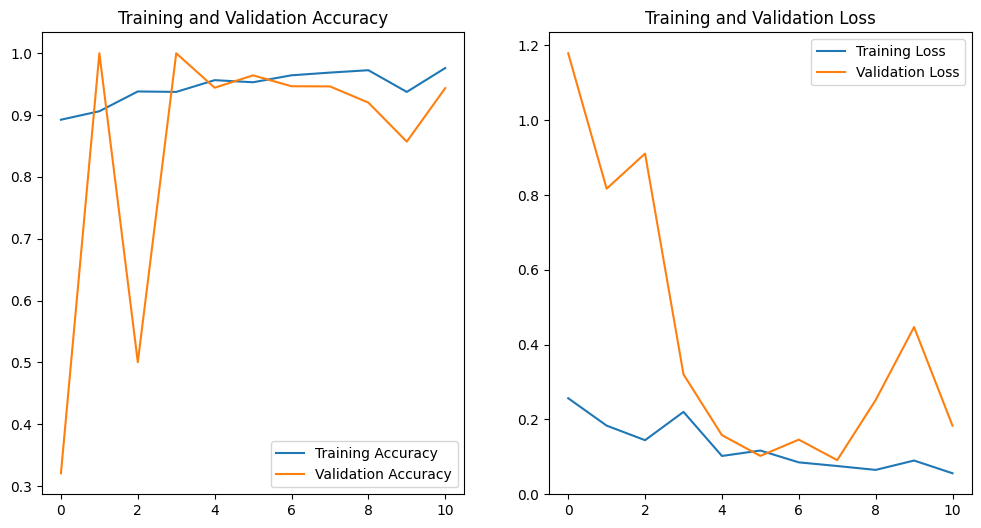

In [7]:
import matplotlib.pyplot as plt

# Graficar la precisión y la pérdida del entrenamiento y validación
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


47/47 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step


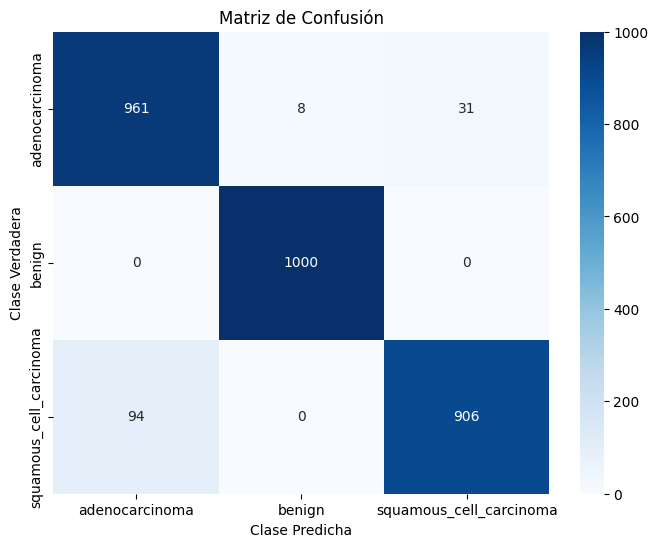

                         precision    recall  f1-score   support

         adenocarcinoma       0.91      0.96      0.94      1000
                 benign       0.99      1.00      1.00      1000
squamous_cell_carcinoma       0.97      0.91      0.94      1000

               accuracy                           0.96      3000
              macro avg       0.96      0.96      0.96      3000
           weighted avg       0.96      0.96      0.96      3000



In [8]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Obtener las predicciones del conjunto de validación
predictions = model.predict(validation_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Obtener las clases verdaderas del conjunto de validación
true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())  # Etiquetas de las clases

# Calcular la matriz de confusión
cm = confusion_matrix(true_classes, predicted_classes)

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.ylabel('Clase Verdadera')
plt.xlabel('Clase Predicha')
plt.title('Matriz de Confusión')
plt.show()

# Imprimir el informe de clasificación
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)
